In [1]:
# Download dataset from Kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)

# --- Import libraries ---
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# If in Jupyter Notebook
# %matplotlib inline

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Enable Plotly notebook mode
init_notebook_mode(connected=True)

!pip install catboost

# Other libraries
import gc
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

# Display full dataframe columns
pd.set_option('display.max_columns', 100)

# --- Constants / Parameters ---
# RandomForestClassifier
RFC_METRIC = 'gini'
NUM_ESTIMATORS = 100
NO_JOBS = 4

# Validation & Test split
VALID_SIZE = 0.20
TEST_SIZE = 0.20

# Cross-Validation
NUMBER_KFOLDS = 5

# Random state for reproducibility
RANDOM_STATE = 2018

# LightGBM training settings
MAX_ROUNDS = 1000
EARLY_STOP = 50
OPT_ROUNDS = 1000
VERBOSE_EVAL = 50


Path to dataset files: /kaggle/input/creditcardfraud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.9 MB/s eta 0:00:00


In [2]:
# Load dataset
import pandas as pd
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot

# Read the CSV file from the downloaded path
data_df = pd.read_csv(path + "/creditcard.csv")

# Print dataset dimensions
print("Credit Card Fraud Detection data - rows:", data_df.shape[0], " columns:", data_df.shape[1])

# Preview the dataset
display(data_df.head())

# Summary statistics
display(data_df.describe())

# --- Check for missing/null values ---
total = data_df.isnull().sum().sort_values(ascending=False)
percent = (data_df.isnull().sum() / data_df.isnull().count() * 100).sort_values(ascending=False)

# Combine and display missing value stats
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
display(missing_data.transpose())

# --- Visualize Class Distribution (Fraud vs Not Fraud) ---
class_counts = data_df["Class"].value_counts()
df_class = pd.DataFrame({'Class': class_counts.index, 'Values': class_counts.values})

# Create bar chart for class distribution
trace = go.Bar(
    x=df_class['Class'],
    y=df_class['Values'],
    name="Credit Card Fraud Class - data imbalance",
    marker=dict(color="Red"),
    text=df_class['Values']
)

layout = dict(
    title='Credit Card Fraud Class Distribution (0 = Not Fraud, 1 = Fraud)',
    xaxis=dict(title='Class'),
    yaxis=dict(title='Number of Transactions'),
    hovermode='closest',
    width=600
)

fig = dict(data=[trace], layout=layout)
iplot(fig, filename='class_distribution')

# --- Time-Based Density Plot of Transactions by Class ---
class_0_time = data_df[data_df['Class'] == 0]["Time"]
class_1_time = data_df[data_df['Class'] == 1]["Time"]

# Prepare data for density plot
hist_data = [class_0_time, class_1_time]
group_labels = ['Not Fraud', 'Fraud']

# Create and plot density distribution
fig_time_density = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig_time_density['layout'].update(
    title='Credit Card Transactions Time Density Plot',
    xaxis=dict(title='Time [s]')
)
iplot(fig_time_density, filename='time_density')

Credit Card Fraud Detection data - rows: 284807  columns: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night in Europe timezone.

Let's look into more details to the time distribution of both classes transaction, as well as to aggregated values of transaction count and amount, per hour. We assume (based on observation of the time distribution of transactions) that the time unit is second.

In [3]:
import pandas as pd
import numpy as np

# Convert 'Time' in seconds to 'Hour' and create a new column
data_df['Hour'] = np.floor(data_df['Time'] / 3600)

# Define aggregation functions for the 'Amount' column
agg_functions = {
    'Amount': ['min', 'max', 'count', 'sum', 'mean', 'median', 'var']
}

# Group by 'Hour' and 'Class', then apply the aggregation
grouped_df = data_df.groupby(['Hour', 'Class']).agg(agg_functions).reset_index()

# Flatten the column MultiIndex
grouped_df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']

# Display the result
grouped_df.head()


,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


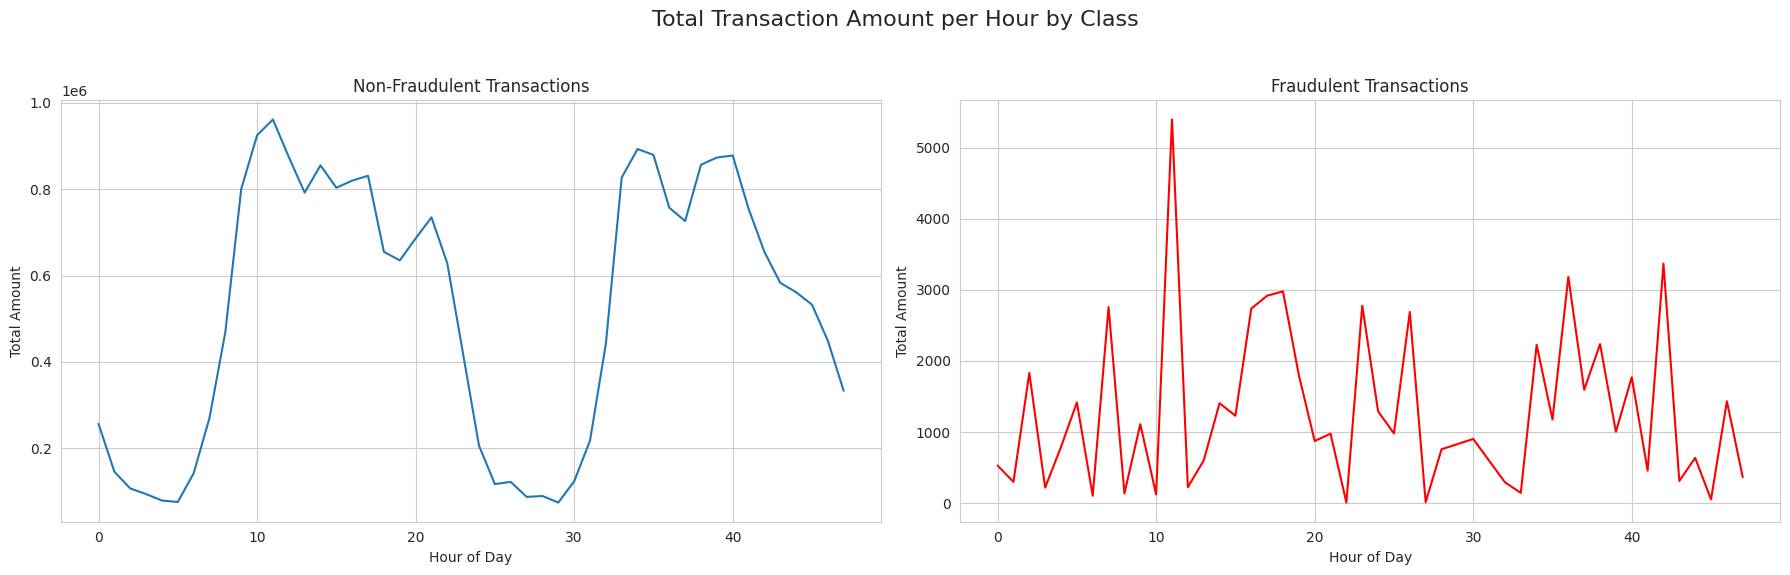

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better aesthetics
sns.set_style("whitegrid")

# Create two subplots: one for Class 0 (non-fraud), one for Class 1 (fraud)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

# Plot for non-fraudulent transactions
sns.lineplot(ax=ax1, x="Hour", y="Sum", data=grouped_df[grouped_df['Class'] == 0])
ax1.set_title("Non-Fraudulent Transactions")
ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Total Amount")

# Plot for fraudulent transactions
sns.lineplot(ax=ax2, x="Hour", y="Sum", data=grouped_df[grouped_df['Class'] == 1], color="red")
ax2.set_title("Fraudulent Transactions")
ax2.set_xlabel("Hour of Day")
ax2.set_ylabel("Total Amount")

# Add an overall title
plt.suptitle("Total Transaction Amount per Hour by Class", fontsize=16)

# Display the plots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


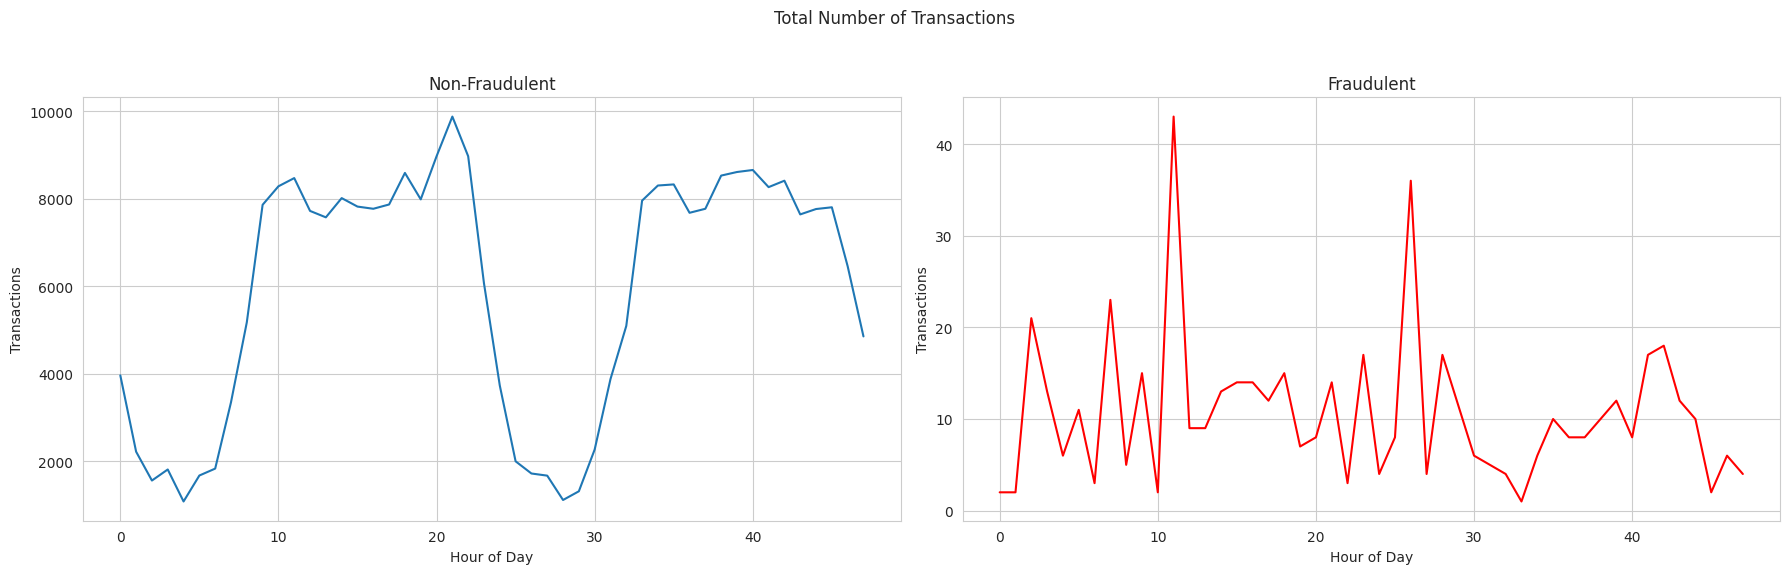

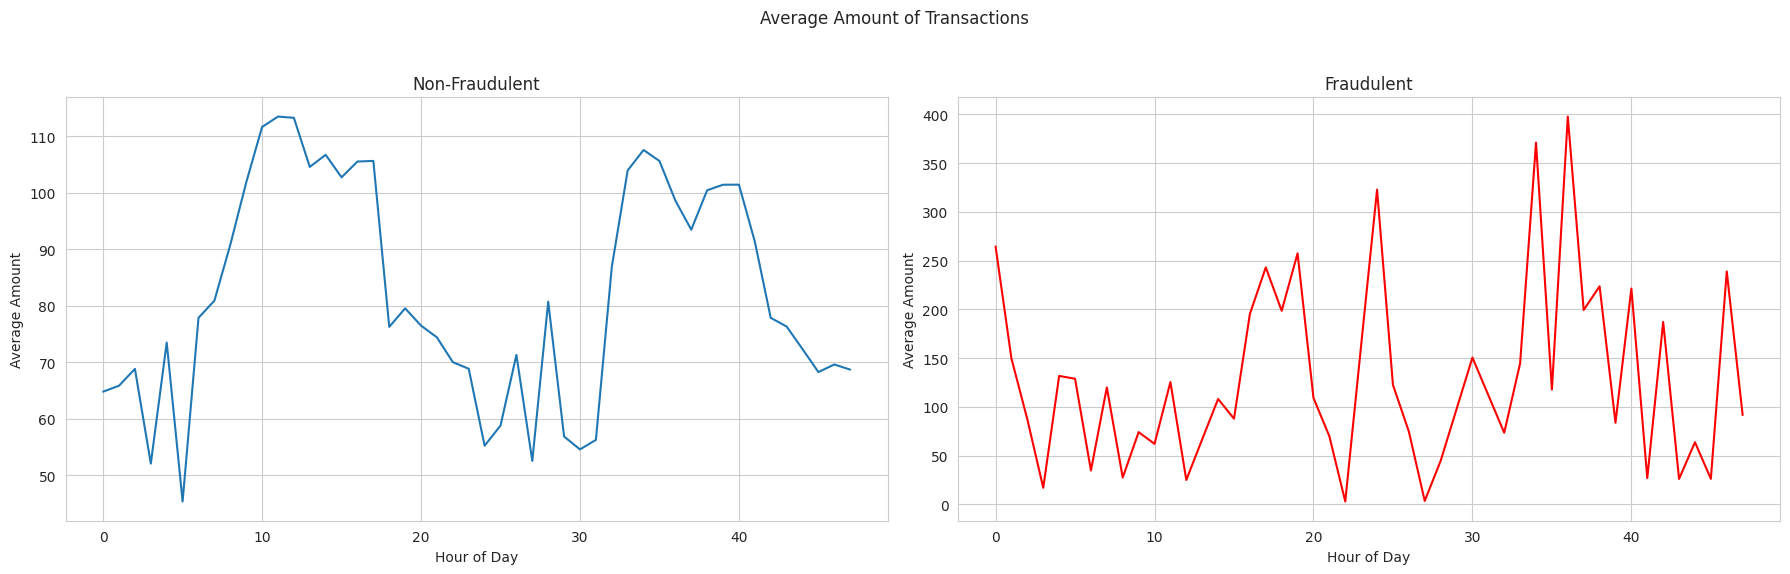

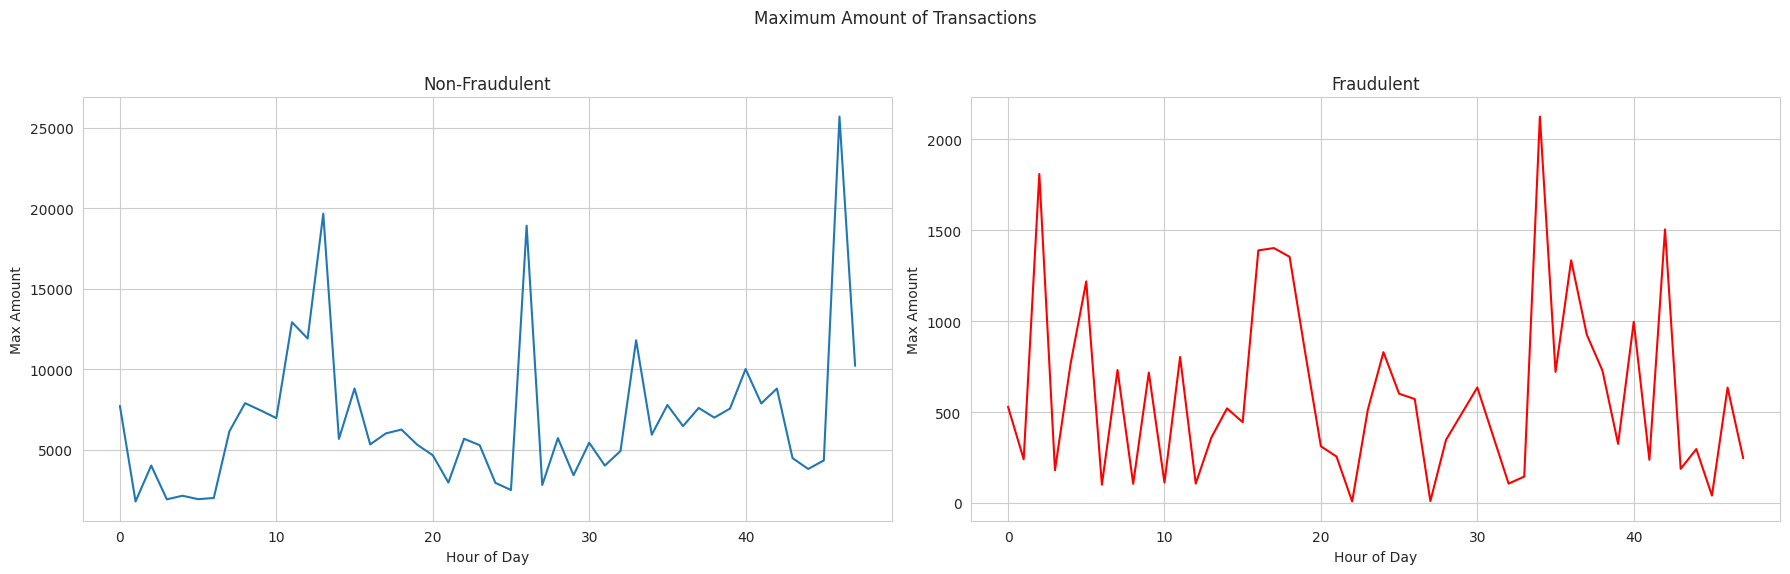

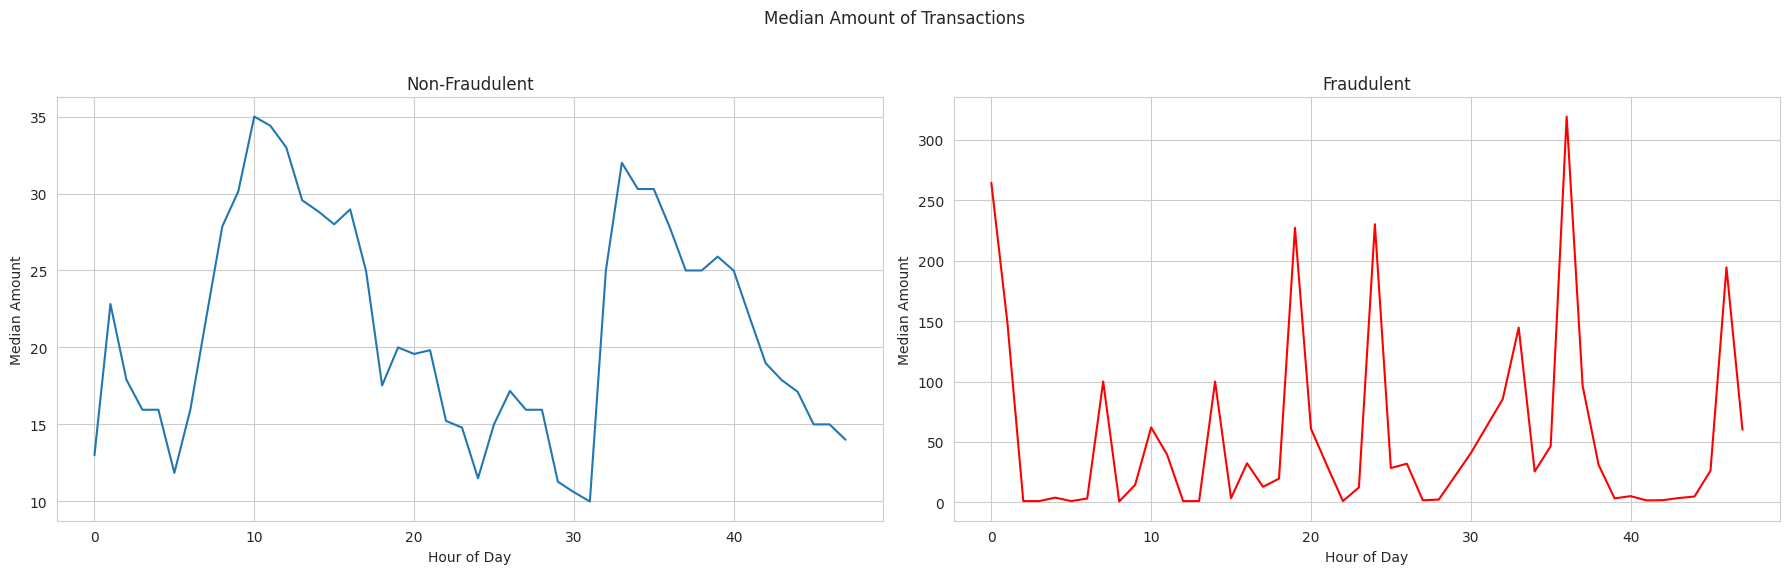

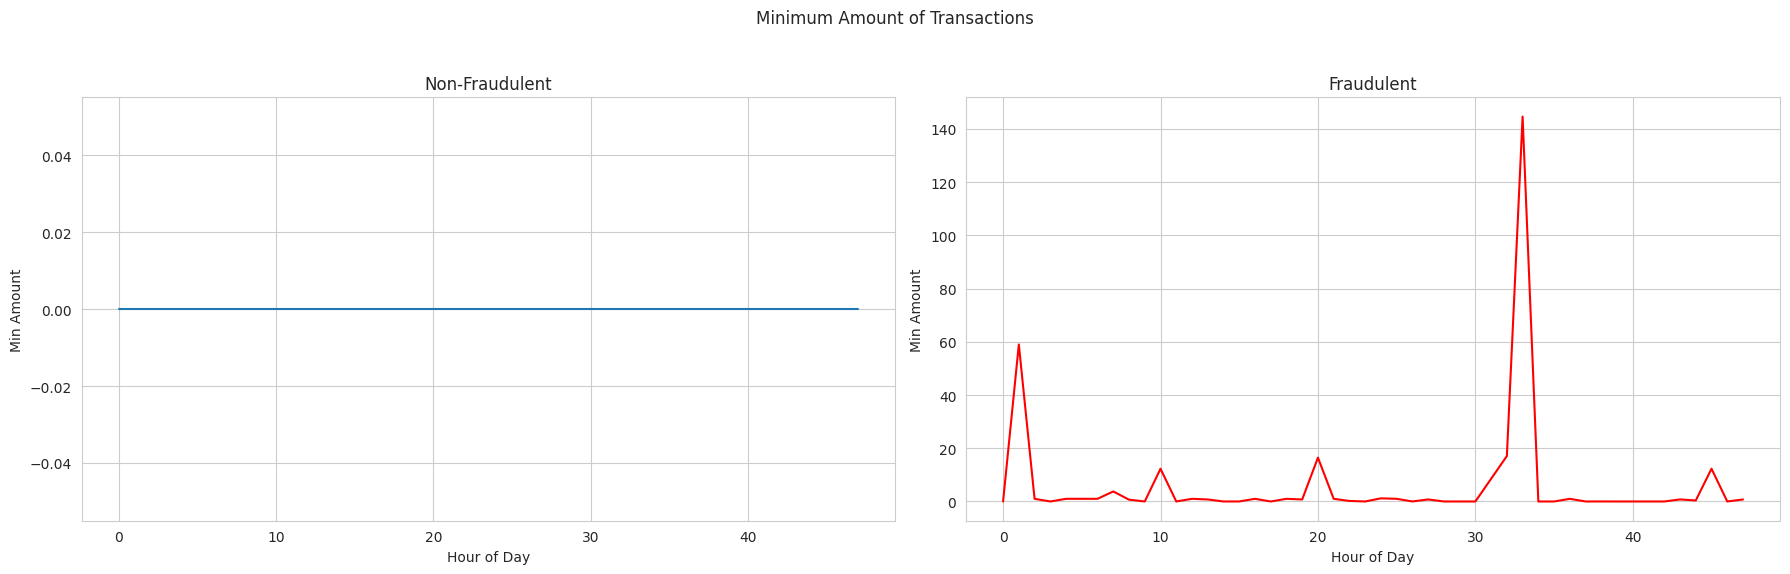

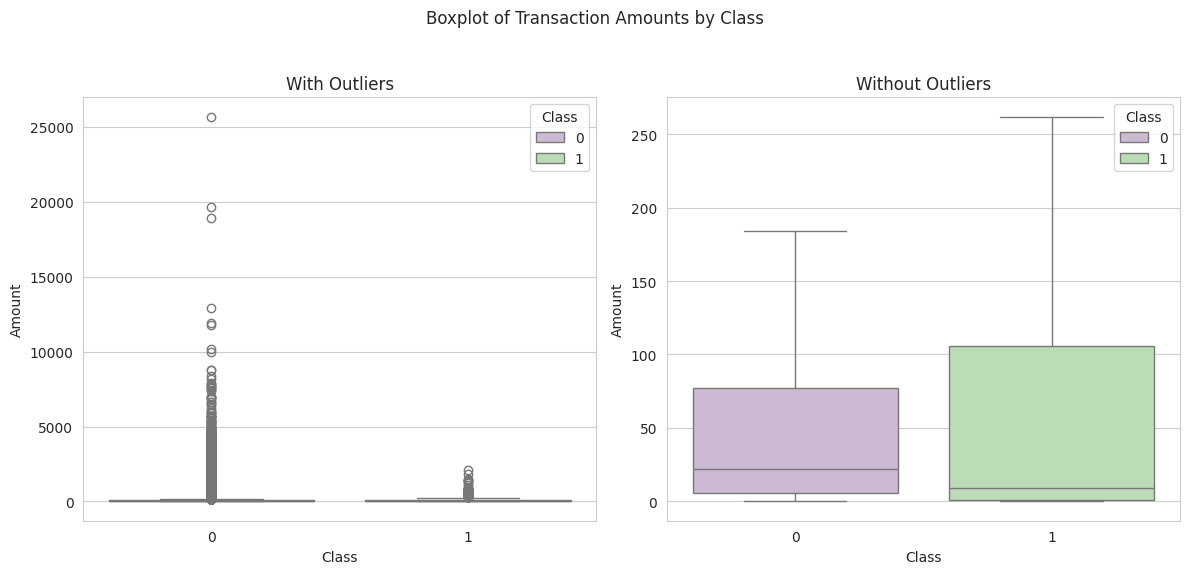

Summary statistics for Class 0 (Non-Fraud):
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Summary statistics for Class 1 (Fraud):
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot
import pandas as pd
import numpy as np

# Seaborn style
sns.set_style("whitegrid")

# Define plotting function to avoid repetition
def dual_lineplot(df, column, title, ylabel):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
    sns.lineplot(ax=ax1, x="Hour", y=column, data=df[df["Class"] == 0])
    sns.lineplot(ax=ax2, x="Hour", y=column, data=df[df["Class"] == 1], color="red")
    ax1.set_title("Non-Fraudulent")
    ax2.set_title("Fraudulent")
    ax1.set_ylabel(ylabel)
    ax2.set_ylabel(ylabel)
    ax1.set_xlabel("Hour of Day")
    ax2.set_xlabel("Hour of Day")
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 1. Total number of transactions per hour
dual_lineplot(grouped_df, column="Transactions", title="Total Number of Transactions", ylabel="Transactions")

# 2. Average amount per transaction per hour
dual_lineplot(grouped_df, column="Mean", title="Average Amount of Transactions", ylabel="Average Amount")

# 3. Maximum amount per transaction per hour
dual_lineplot(grouped_df, column="Max", title="Maximum Amount of Transactions", ylabel="Max Amount")

# 4. Median amount per transaction per hour
dual_lineplot(grouped_df, column="Median", title="Median Amount of Transactions", ylabel="Median Amount")

# 5. Minimum amount per transaction per hour
dual_lineplot(grouped_df, column="Min", title="Minimum Amount of Transactions", ylabel="Min Amount")

# 6. Boxplot of transaction amounts for each class
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
sns.boxplot(ax=ax1, x="Class", y="Amount", hue="Class", data=data_df, palette="PRGn", showfliers=True)
ax1.set_title("With Outliers")
sns.boxplot(ax=ax2, x="Class", y="Amount", hue="Class", data=data_df, palette="PRGn", showfliers=False)
ax2.set_title("Without Outliers")
plt.suptitle("Boxplot of Transaction Amounts by Class")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 7. Summary statistics for Class 0 and Class 1
tmp = data_df[['Amount', 'Class']].copy()
class_0 = tmp[tmp['Class'] == 0]['Amount']
class_1 = tmp[tmp['Class'] == 1]['Amount']

print("Summary statistics for Class 0 (Non-Fraud):")
print(class_0.describe())

print("\nSummary statistics for Class 1 (Fraud):")
print(class_1.describe())

# 8. Scatter plot of fraudulent transactions (Plotly)
fraud = data_df[data_df['Class'] == 1]

trace = go.Scatter(
    x=fraud['Time'],
    y=fraud['Amount'],
    mode='markers',
    name='Amount',
    marker=dict(
        color='rgb(238,23,11)',
        line=dict(color='red', width=1),
        opacity=0.5
    ),
    text=fraud['Amount']
)

layout = dict(
    title='Amount of Fraudulent Transactions Over Time',
    xaxis=dict(title='Time [s]', showticklabels=True),
    yaxis=dict(title='Amount'),
    hovermode='closest'
)

fig = dict(data=[trace], layout=layout)
iplot(fig, filename='fraud-amount')

Interactive scatter plot of fraudulent transactions using Plotly.

Correlation heatmap of all features.

Linear regression plots comparing features (V20, V7, V2, V5) to transaction amount, split by fraud class.

KDE distribution plots for all features by class using a grid layout.

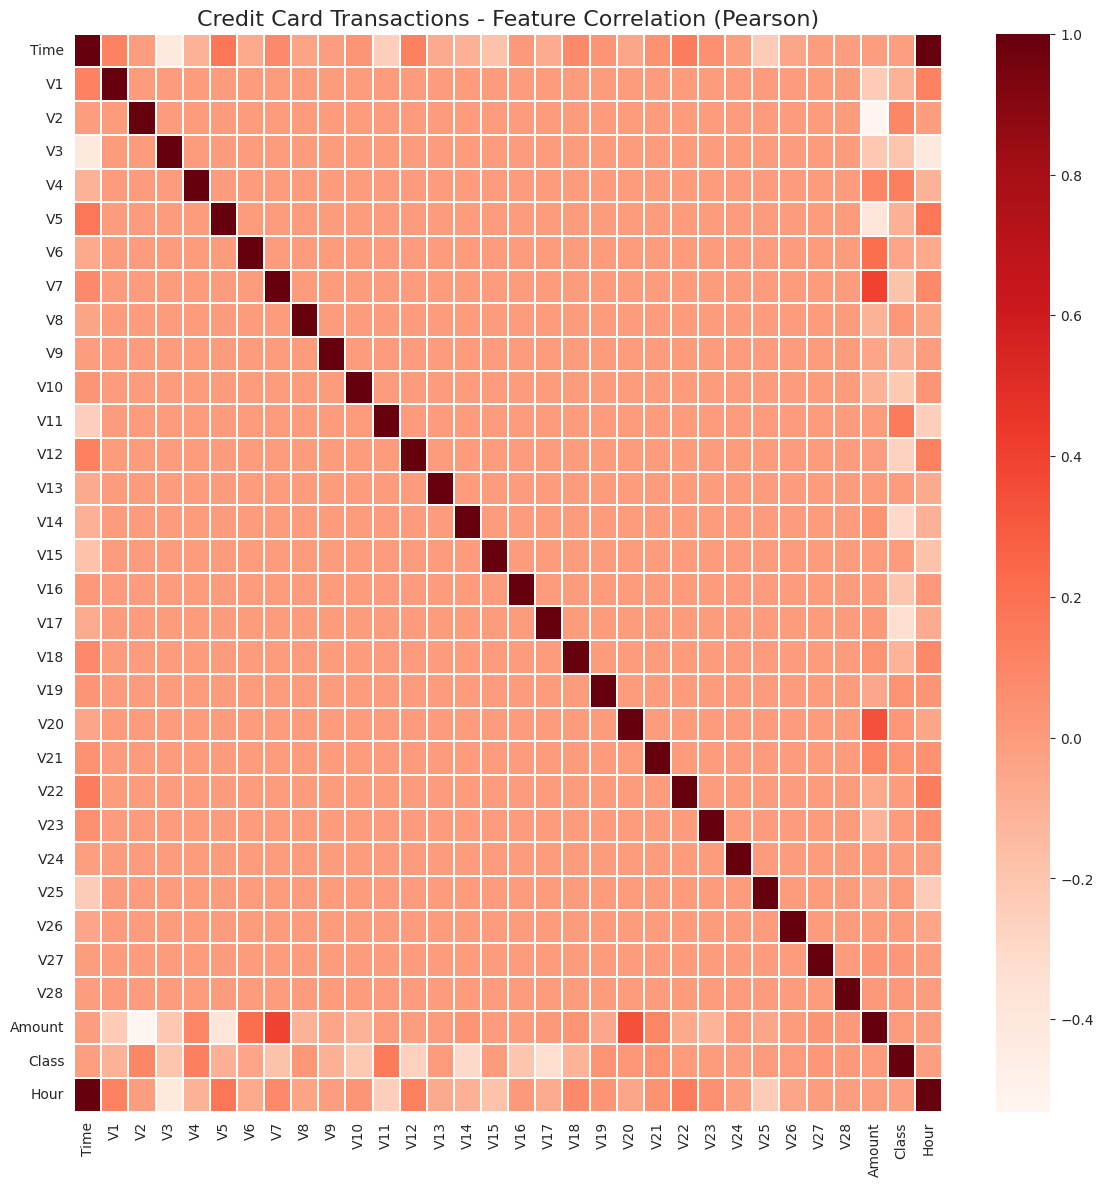

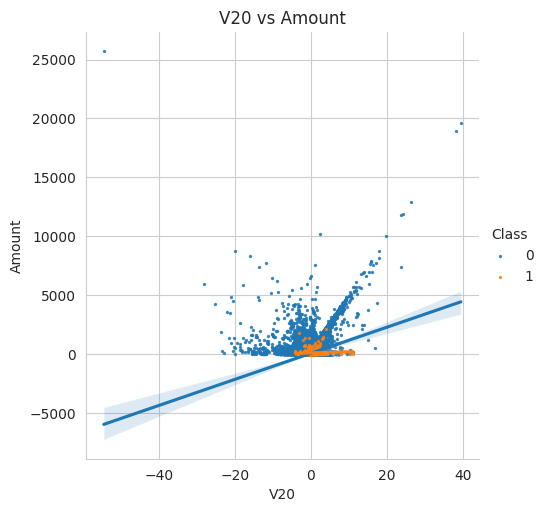

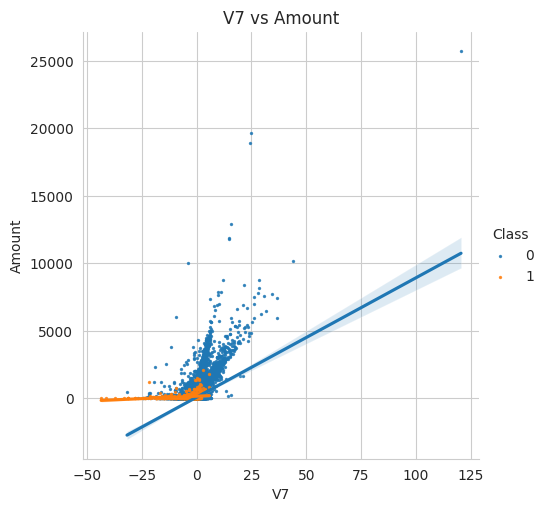

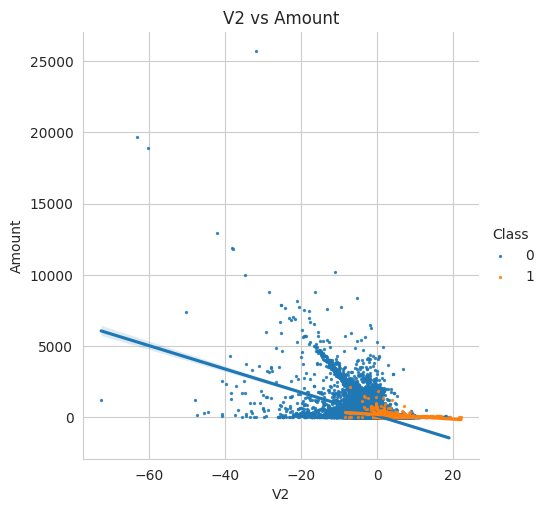

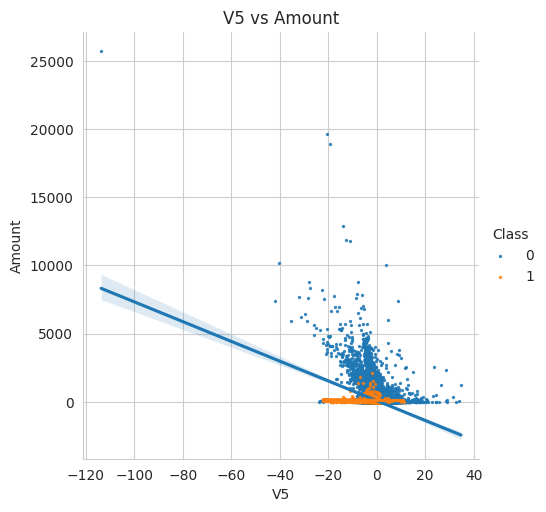

/tmp/ipython-input-6-3678133679.py:83: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/tmp/ipython-input-6-3678133679.py:84: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

/tmp/ipython-input-6-3678133679.py:87: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



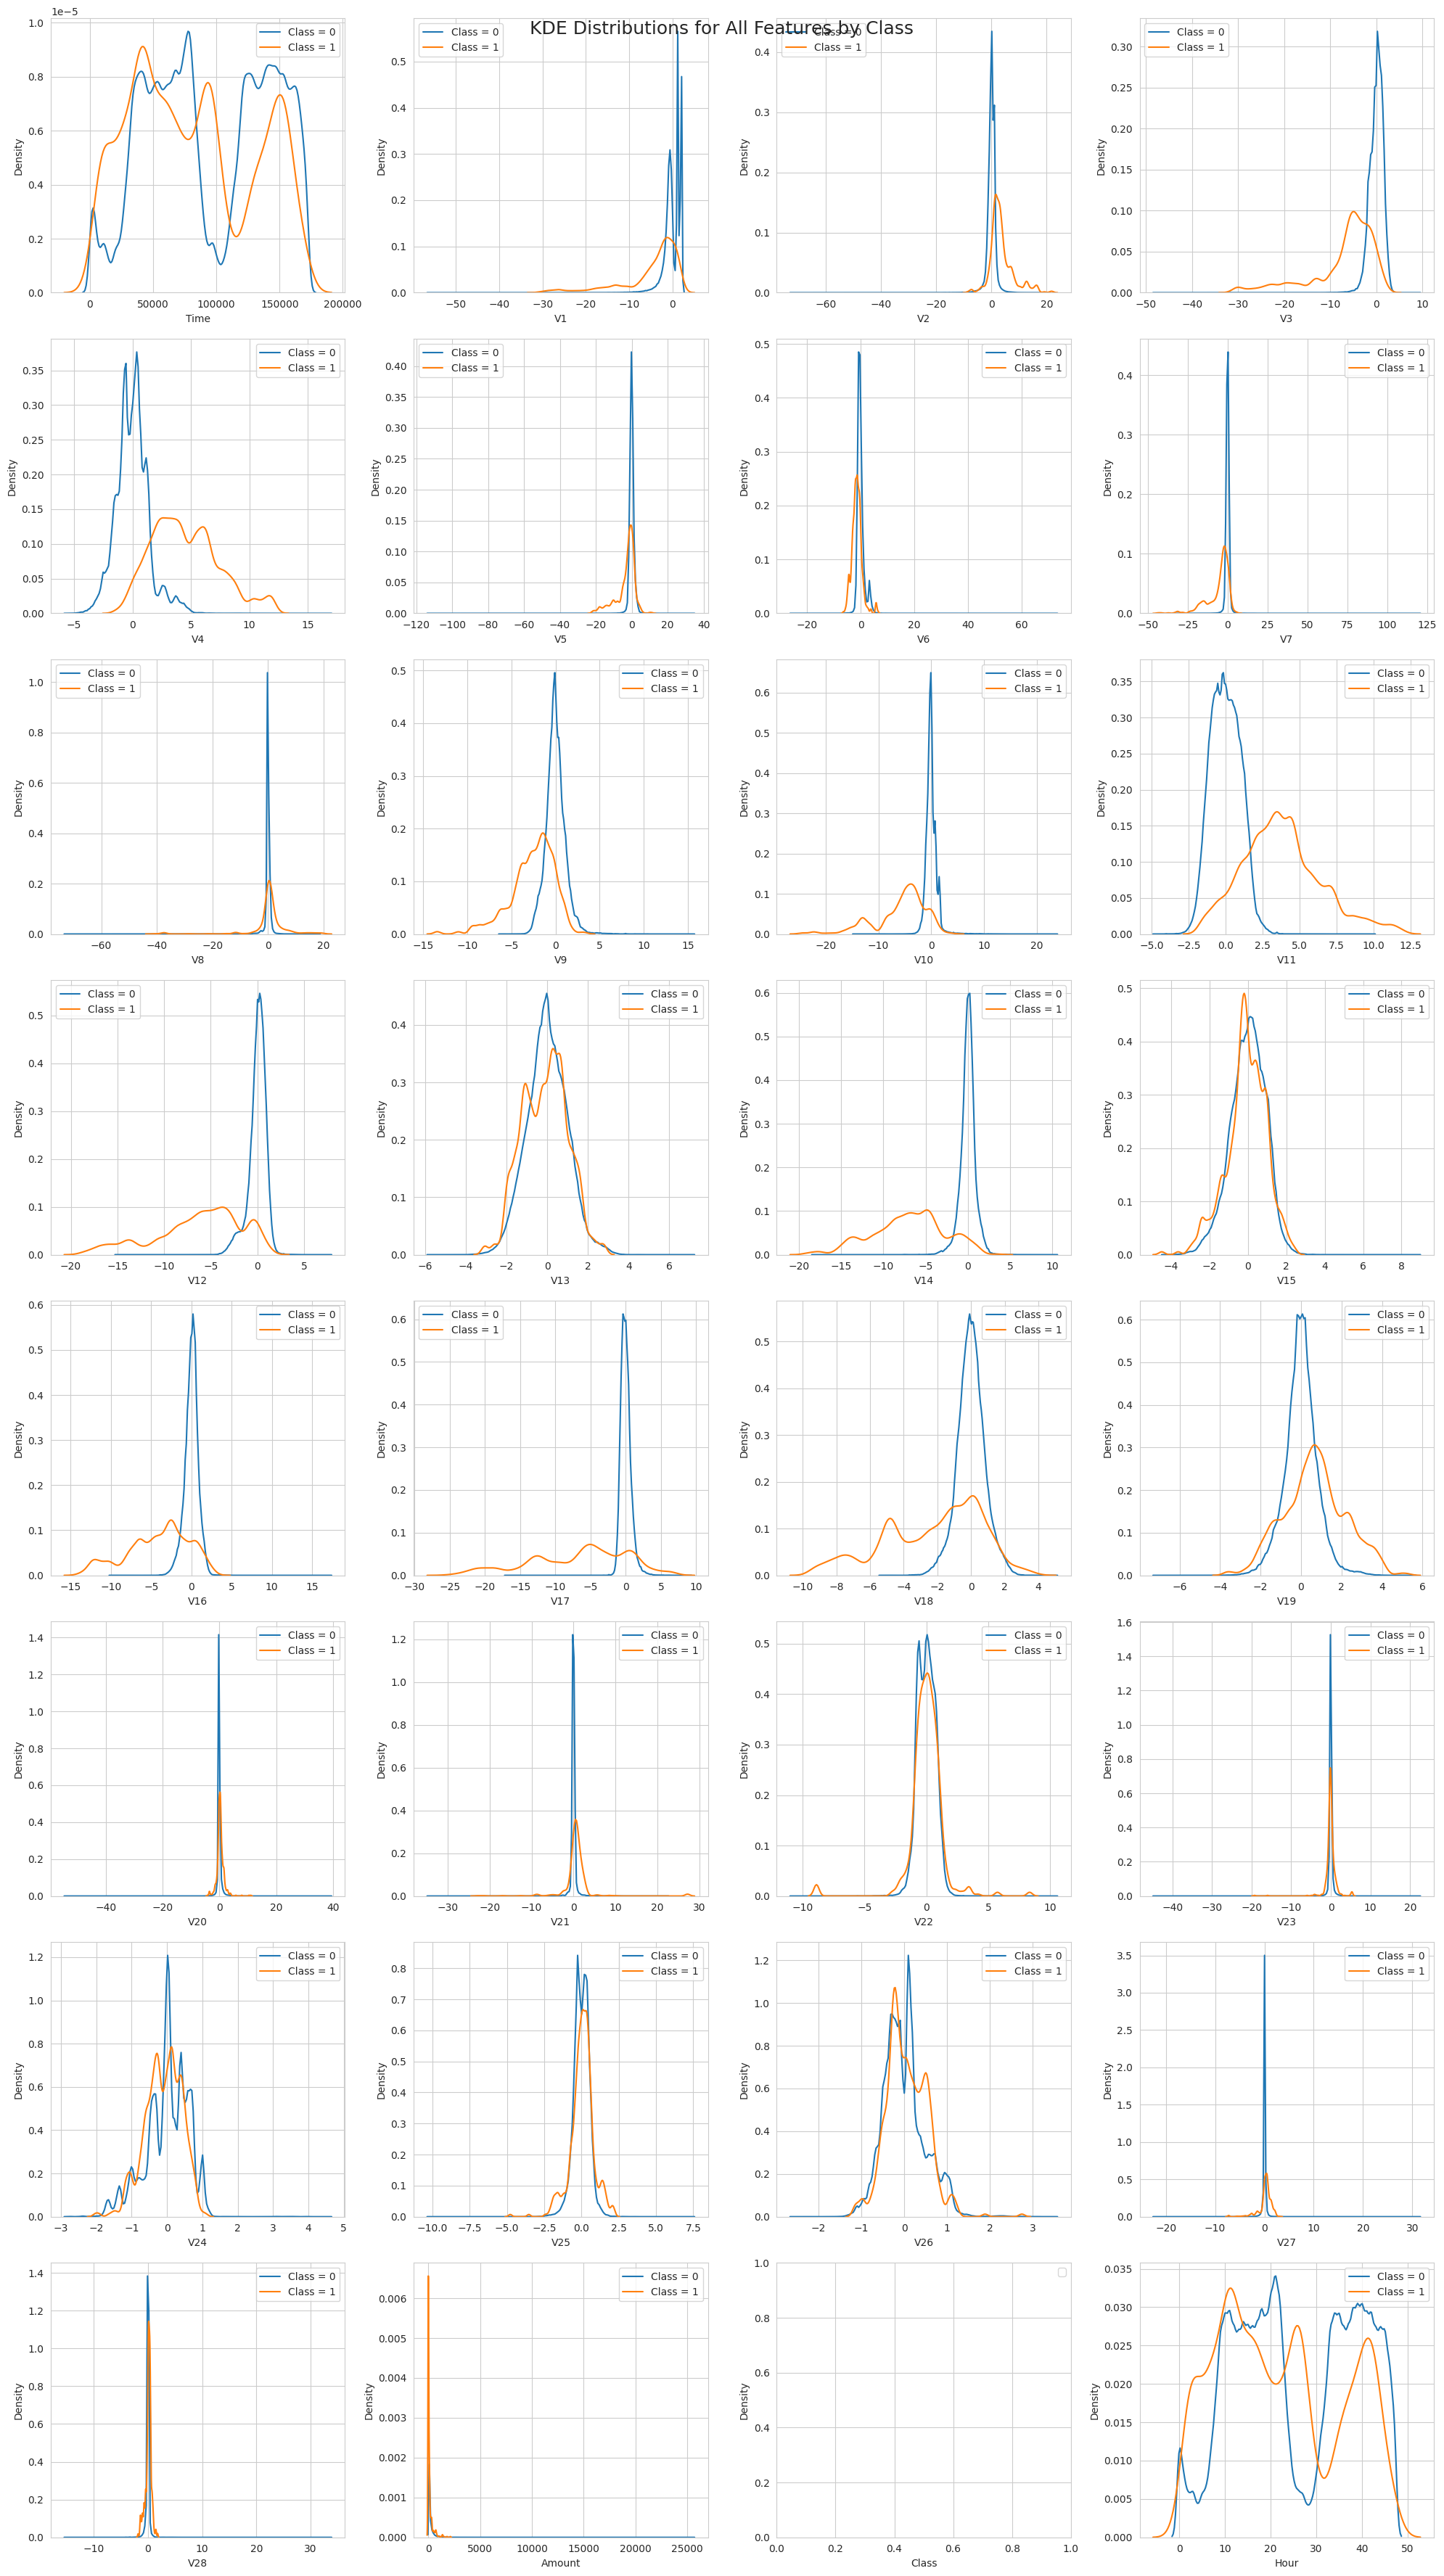

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot
import numpy as np

# --- 1. Plotly scatter plot of fraudulent transactions ---
fraud = data_df[data_df['Class'] == 1]

trace = go.Scatter(
    x=fraud['Time'],
    y=fraud['Amount'],
    mode='markers',
    name='Amount',
    marker=dict(
        color='rgb(238,23,11)',
        line=dict(color='red', width=1),
        opacity=0.5
    ),
    text=fraud['Amount']
)

layout = dict(
    title='Amount of Fraudulent Transactions Over Time',
    xaxis=dict(title='Time [s]', showticklabels=True),
    yaxis=dict(title='Amount'),
    hovermode='closest'
)

fig = dict(data=[trace], layout=layout)
iplot(fig, filename='fraud-amount')

# --- 2. Correlation Heatmap (Pearson) ---
plt.figure(figsize=(14, 14))
plt.title('Credit Card Transactions - Feature Correlation (Pearson)', fontsize=16)
corr_matrix = data_df.corr()
sns.heatmap(corr_matrix,
            xticklabels=corr_matrix.columns,
            yticklabels=corr_matrix.columns,
            linewidths=0.1,
            cmap="Reds",
            annot=False)
plt.show()

# --- 3. Linear Model Plots: Relationship between features and amount by class ---
sns.set_style("whitegrid")

# V20 vs Amount
sns.lmplot(x='V20', y='Amount', data=data_df, hue='Class', fit_reg=True, scatter_kws={'s': 2})
plt.title("V20 vs Amount")
plt.show()

# V7 vs Amount
sns.lmplot(x='V7', y='Amount', data=data_df, hue='Class', fit_reg=True, scatter_kws={'s': 2})
plt.title("V7 vs Amount")
plt.show()

# V2 vs Amount
sns.lmplot(x='V2', y='Amount', data=data_df, hue='Class', fit_reg=True, scatter_kws={'s': 2})
plt.title("V2 vs Amount")
plt.show()

# V5 vs Amount
sns.lmplot(x='V5', y='Amount', data=data_df, hue='Class', fit_reg=True, scatter_kws={'s': 2})
plt.title("V5 vs Amount")
plt.show()

# --- 4. KDE plots for all features across both classes ---
variables = data_df.columns.values
num_features = len(variables)
cols = 4
rows = int(np.ceil(num_features / cols))

t0 = data_df[data_df['Class'] == 0]
t1 = data_df[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure(figsize=(20, 36))
plt.suptitle("KDE Distributions for All Features by Class", fontsize=18)

for idx, feature in enumerate(variables):
    plt.subplot(rows, cols, idx + 1)
    sns.kdeplot(t0[feature], bw_adjust=0.5, label="Class = 0")
    sns.kdeplot(t1[feature], bw_adjust=0.5, label="Class = 1")
    plt.xlabel(feature, fontsize=10)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()

plt.show()

Random Forest and AdaBoost

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define target and features
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
              'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
              'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
              'V28', 'Amount']

# Split dataset into train, validation, and test
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True)
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True)

# ========== RANDOM FOREST CLASSIFIER ==========
print("\n--- Random Forest Classifier ---")
clf_rf = RandomForestClassifier(
    n_jobs=NO_JOBS,
    random_state=RANDOM_STATE,
    criterion=RFC_METRIC,
    n_estimators=NUM_ESTIMATORS,
    verbose=False
)

# Train and predict
clf_rf.fit(train_df[predictors], train_df[target].values)
preds_rf = clf_rf.predict(valid_df[predictors])

# Feature Importance
feat_imp_rf = pd.DataFrame({'Feature': predictors, 'Feature importance': clf_rf.feature_importances_})
feat_imp_rf = feat_imp_rf.sort_values(by='Feature importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x='Feature', y='Feature importance', data=feat_imp_rf)
plt.title('Random Forest - Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Confusion Matrix
cm_rf = pd.crosstab(valid_df[target], preds_rf, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(5, 5))
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            linewidths=0.5, linecolor='darkblue')
plt.title('Random Forest - Confusion Matrix')
plt.show()

# ROC AUC
roc_rf = roc_auc_score(valid_df[target], preds_rf)
print("Random Forest ROC AUC Score:", round(roc_rf, 4))

# ========== ADABOOST CLASSIFIER ==========
print("\n--- AdaBoost Classifier ---")
clf_ab = AdaBoostClassifier(
    random_state=RANDOM_STATE,
    algorithm='SAMME',
    learning_rate=0.8,
    n_estimators=NUM_ESTIMATORS
)

# Train and predict
clf_ab.fit(train_df[predictors], train_df[target].values)
preds_ab = clf_ab.predict(valid_df[predictors])

# Feature Importance
feat_imp_ab = pd.DataFrame({'Feature': predictors, 'Feature importance': clf_ab.feature_importances_})
feat_imp_ab = feat_imp_ab.sort_values(by='Feature importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x='Feature', y='Feature importance', data=feat_imp_ab)
plt.title('AdaBoost - Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Confusion Matrix
cm_ab = pd.crosstab(valid_df[target], preds_ab, rownames=['Actual'], colnames=['Predicted'])
plt.figure(figsize=(5, 5))
sns.heatmap(cm_ab, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            linewidths=0.5, linecolor='darkblue')
plt.title('AdaBoost - Confusion Matrix')
plt.show()

# ROC AUC
roc_ab = roc_auc_score(valid_df[target], preds_ab)
print("AdaBoost ROC AUC Score:", round(roc_ab, 4))


--- Random Forest Classifier ---


Common Parameters

In [ ]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
              'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
              'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

# Split dataset
train_df, test_df = train_test_split(data_df, test_size=0.20, random_state=2018, shuffle=True)
train_df, valid_df = train_test_split(train_df, test_size=0.20, random_state=2018, shuffle=True)



CatBoost Classifier

In [ ]:
clf = CatBoostClassifier(
    iterations=500,
    learning_rate=0.02,
    depth=12,
    eval_metric='AUC',
    random_seed=2018,
    bagging_temperature=0.2,
    od_type='Iter',
    metric_period=50,
    od_wait=100,
    verbose=False
)
clf.fit(train_df[predictors], train_df[target])

# Predict
preds = clf.predict(valid_df[predictors])
print("CatBoost AUC:", roc_auc_score(valid_df[target], preds))

# Feature Importance
feat_imp = pd.DataFrame({'Feature': predictors, 'Importance': clf.feature_importances_})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 4))
sns.barplot(data=feat_imp, x='Feature', y='Importance')
plt.xticks(rotation=90)
plt.title('CatBoost - Feature Importance')
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(valid_df[target], preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('CatBoost - Confusion Matrix')
plt.show()


XGBoost

In [ ]:
dtrain = xgb.DMatrix(train_df[predictors], label=train_df[target])
dvalid = xgb.DMatrix(valid_df[predictors], label=valid_df[target])
dtest = xgb.DMatrix(test_df[predictors], label=test_df[target])

params = {
    'objective': 'binary:logistic',
    'eta': 0.039,
    'max_depth': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'eval_metric': 'auc',
    'random_state': 2018
}

model = xgb.train(params, dtrain, num_boost_round=1000,
                  evals=[(dtrain, 'train'), (dvalid, 'valid')],
                  early_stopping_rounds=50, verbose_eval=50)

# Plot feature importance
xgb.plot_importance(model, height=0.8, title="XGBoost - Feature Importance", color="green")
plt.show()

# Predict and evaluate
preds = model.predict(dtest)
print("XGBoost AUC:", roc_auc_score(test_df[target], preds))
